# AdaGrad

## Definition: AdaGrad (Adaptive Gradient Algorithm)

AdaGrad (Duchi et al., 2011) adapts the learning rate **per parameter** using
the history of squared gradients. Directions with consistently large gradients
(steep or unstable regions prone to overshooting) get smaller steps, while
directions with small or rare gradients get larger ones. The squared-gradient
history acts as a heuristic measure of how “safe” or “risky” each direction is.

Given the gradient:
$$
g_t = \nabla_\theta L(\theta_t),
$$

AdaGrad accumulates squared gradients:
$$
s_{t+1} = s_{t} + g_{t}^2,
$$

and updates parameters using:
$$
\theta_{t+1}
= \theta_{t}
- \eta\, \frac{g_{t}}{\sqrt{s_{t+1}} + \varepsilon}.
$$
where the operations here are ocmponentwise.

**Note:** Since $s_{t}$ grows monotonically, the effective learning rate

$1/\sqrt{s_{t}}$ shrinks to zero, causing AdaGrad to stall. RMSProp and Adam
fix this by using an exponential moving average instead of an unbounded sum.

## Code: AdaGrad

In [ ]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim.optimizer import Optimizer

from models.deep_learning.mlp import MLP

In [ ]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-2, eps=1e-10, weight_decay=0.0):
        defaults = {
            "lr": lr,
            "eps": eps,
            "weight_decay": weight_decay,
        }
        # Parent class creates param_groups and self.state
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single AdaGrad update step."""
        for group in self.param_groups:
            lr = group["lr"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad

                # Optional L2 weight decay: grad <- grad + λ θ
                if weight_decay != 0.0:
                    grad = grad.add(p, alpha=weight_decay)

                # Initialize state for accumulator parameter s_0 = 0
                state = self.state[p]
                if "accumulator" not in state:
                    state["accumulator"] = torch.zeros_like(p)

                s = state["accumulator"]

                # s_{t+1} = s_t + g_t^2 (elementwise square)
                s.add_(grad.pow(2))

                # Denominator: sqrt(s_{t+1}) + eps
                denom = s.sqrt().add_(eps)

                # Parameter update:
                # θ <- θ - lr * g / denom
                p.addcdiv_(grad, denom, value=-lr)

### Data

In [ ]:
def f(x):
    return 1+2*x**2

N = 20
xs = (4*torch.rand(N)-2).unsqueeze(1)
ys = f(xs) + 0.5*torch.randn(N).unsqueeze(1)

x = torch.linspace(-2,2,100,requires_grad=True)
x_eval = torch.linspace(-2,2,100)
torch.manual_seed(1)

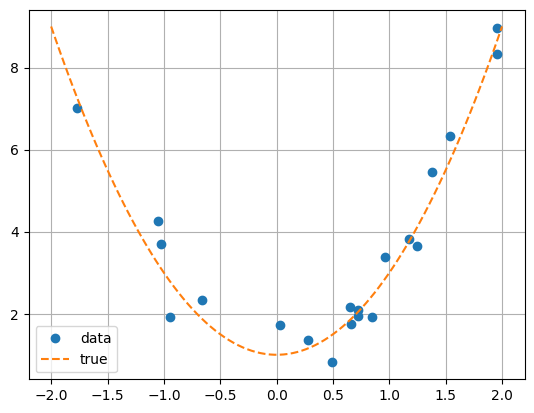

In [ ]:
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x.detach().numpy(), f(x).detach().numpy(), '--',label='true')
plt.legend()
plt.grid()
plt.show()


### Training loop

In [ ]:
def train(model, opt, loss_fn, data, epochs=20, batch_size=1):
    xs, ys = data
    N = xs.shape[0]
    model.train()
    losses = []
    for epoch in range(epochs):
        perm = torch.randperm(N)  # shuffle for stochasticity each epoch
        for i in range(0, N, batch_size):
            batch_idx = perm[i:i + batch_size]
            x = xs[batch_idx]
            y = ys[batch_idx]
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")   
    return losses

def compare_losses(loss,nn_loss,title):
    plt.plot(nn_loss,linestyle="-",label="nn_loss")
    plt.plot(loss,linestyle="--",label="loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Parameters

In [ ]:
lr = 0.001
momentum = 0.9
dampening = 0.0
weight_decay= 0.001
nesterov = False

loss_fn = nn.MSELoss()  

### pytorch

In [ ]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.ReLU())
opt = torch.optim.Adagrad(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

nn_loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)

Epoch 1/150, Loss: 18.9333
Epoch 2/150, Loss: 13.4454
Epoch 3/150, Loss: 9.0794
Epoch 4/150, Loss: 5.3208
Epoch 5/150, Loss: 3.0378
Epoch 6/150, Loss: 2.2614
Epoch 7/150, Loss: 2.0526
Epoch 8/150, Loss: 1.9141
Epoch 9/150, Loss: 1.7907
Epoch 10/150, Loss: 1.6740
Epoch 11/150, Loss: 1.5641
Epoch 12/150, Loss: 1.4597
Epoch 13/150, Loss: 1.3622
Epoch 14/150, Loss: 1.2707
Epoch 15/150, Loss: 1.1840
Epoch 16/150, Loss: 1.1009
Epoch 17/150, Loss: 1.0232
Epoch 18/150, Loss: 0.9498
Epoch 19/150, Loss: 0.8809
Epoch 20/150, Loss: 0.8165
Epoch 21/150, Loss: 0.7569
Epoch 22/150, Loss: 0.7007
Epoch 23/150, Loss: 0.6497
Epoch 24/150, Loss: 0.6030
Epoch 25/150, Loss: 0.5598
Epoch 26/150, Loss: 0.5201
Epoch 27/150, Loss: 0.4842
Epoch 28/150, Loss: 0.4519
Epoch 29/150, Loss: 0.4230
Epoch 30/150, Loss: 0.3978
Epoch 31/150, Loss: 0.3746
Epoch 32/150, Loss: 0.3538
Epoch 33/150, Loss: 0.3356
Epoch 34/150, Loss: 0.3196
Epoch 35/150, Loss: 0.3059
Epoch 36/150, Loss: 0.2939
Epoch 37/150, Loss: 0.2834
Epoch 38

### Custom

Epoch 1/150, Loss: 18.9333
Epoch 2/150, Loss: 13.4454
Epoch 3/150, Loss: 9.0794
Epoch 4/150, Loss: 5.3208
Epoch 5/150, Loss: 3.0378
Epoch 6/150, Loss: 2.2614
Epoch 7/150, Loss: 2.0526
Epoch 8/150, Loss: 1.9141
Epoch 9/150, Loss: 1.7907
Epoch 10/150, Loss: 1.6740
Epoch 11/150, Loss: 1.5641
Epoch 12/150, Loss: 1.4597
Epoch 13/150, Loss: 1.3622
Epoch 14/150, Loss: 1.2707
Epoch 15/150, Loss: 1.1840
Epoch 16/150, Loss: 1.1009
Epoch 17/150, Loss: 1.0232
Epoch 18/150, Loss: 0.9498
Epoch 19/150, Loss: 0.8809
Epoch 20/150, Loss: 0.8165
Epoch 21/150, Loss: 0.7569
Epoch 22/150, Loss: 0.7007
Epoch 23/150, Loss: 0.6497
Epoch 24/150, Loss: 0.6030
Epoch 25/150, Loss: 0.5598
Epoch 26/150, Loss: 0.5201
Epoch 27/150, Loss: 0.4842
Epoch 28/150, Loss: 0.4519
Epoch 29/150, Loss: 0.4230
Epoch 30/150, Loss: 0.3978
Epoch 31/150, Loss: 0.3746
Epoch 32/150, Loss: 0.3538
Epoch 33/150, Loss: 0.3356
Epoch 34/150, Loss: 0.3196
Epoch 35/150, Loss: 0.3059
Epoch 36/150, Loss: 0.2939
Epoch 37/150, Loss: 0.2834
Epoch 38

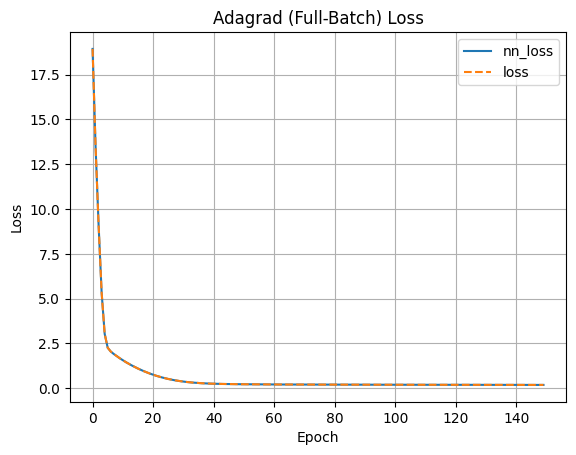

In [ ]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.ReLU())
opt = Adagrad(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)
compare_losses(loss,nn_loss,"Adagrad (Full-Batch) Loss")

# Evaluation

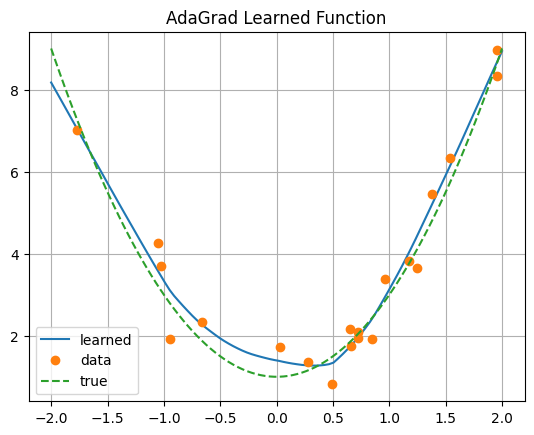

In [ ]:
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='learned')
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.title("AdaGrad Learned Function")
plt.legend()
plt.grid()
plt.show()